The big picture idea here is that I want to build a machine learning model that can predict when a county will have a high (>75th percentile) rate of COVID fatalities.  I have a wide range of data from countyhealthrankings.org (from 2019), the Social Vulnerability Index (2018) that I will use to predict.

Then I will pull out the most important factors of that model. We have a lot of data that is moderately correlated with COVID fatality rates and often highly correlated with each other. So the machine learning model will help tease out what is really important within the raw data, in a way that minimizes my own biases.

First, a bunch of imports:

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeClassifierCV, Lasso, LogisticRegressionCV, LassoLarsCV, ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
import pandas as pd
from sklearn.metrics import roc_auc_score
from COVID_data import prepare_model_data

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import pprint
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from prettytable import PrettyTable


class config:
    USE_CACHE = True
    CACHE_DIR = "/Users/caseydurfee/msds/data_mining_final_project/cache"

from COVID_data import all_data
data = all_data.get_all_data(config)

Let's look at correlations in year 1 of the pandemic versus year 2 and see if there were changes.  Note that we are looking at all factors, including ones with large rates of missing data, which will artificially inflate those correlation scores. Some of these factors won't be used by the model, because I am throwing out any fields where more than 5% of counties have missing data.

Here are the top 10 factors for each year, filtering out correlations with other death rates.

In [3]:
print("Year One")
death_rate_corr = data.corr()['DEATH_RATE_FIRST_YEAR']

# omicron, alpha, delta, etc. death rates are not interesting here
death_cols = list(data.filter(regex = 'DEATH'))

y1_corr = death_rate_corr.reindex(death_rate_corr.abs().sort_values(ascending=False).index) \
    .drop(death_cols)


pt = PrettyTable()
pt.field_names = ['Factor', 'r^2 (year one)']    

for x in y1_corr[:10].index:
    pt.add_row([x, round(y1_corr[x], 3)])

print(pt)

death_rate_corr = data.corr()['DEATH_RATE_SECOND_YEAR']

death_cols = list(data.filter(regex = 'DEATH'))

y2_corr = death_rate_corr.reindex(death_rate_corr.abs().sort_values(ascending=False).index) \
    .drop(death_cols)
pt = PrettyTable()
pt.field_names = ['Factor', 'r^2 (year two)']    
for x in y2_corr[:25].index:
    pt.add_row([x, round(y2_corr[x], 3)])

print(pt)


Year One
+-----------------------------------------+----------------+
|                  Factor                 | r^2 (year one) |
+-----------------------------------------+----------------+
| Age-Adjusted Mortality (Hispanic) (CHR) |     0.376      |
|          Teen Birth Rate (CHR)          |     0.351      |
|        % Disconnected Youth (CHR)       |     0.338      |
|         MV Mortality Rate (CHR)         |     0.337      |
|          % No HS Diploma (SVI)          |     0.321      |
|           Homicide Rate (CHR)           |      0.32      |
| Years of Potential Life Lost Rate (CHR) |     0.311      |
|        Child Mortality Rate (CHR)       |     0.305      |
|       Age-Adjusted Mortality (CHR)      |     0.304      |
|       % Physically Inactive (CHR)       |     0.299      |
+-----------------------------------------+----------------+
+-----------------------------------------+----------------+
|                  Factor                 | r^2 (year two) |
+--------------

Let's take the top 10 correlations from year 1 and year 2 and see how they've changed.

In [38]:
top_cols_in_either = y1_corr[:20].index.union(y2_corr[:20].index)

pt = PrettyTable()
pt.field_names = ['Name', 'Year 1 r^2', 'Year 2 r^2']

rows = []
for c in top_cols_in_either:
    row = [c, round(y1_corr[c], 3), round(y2_corr[c], 3)]
    # pt.add_row(row)
    rows.append(row)

sorted_rows = sorted(rows, key=lambda x: abs(x[1]) + abs(x[2]), reverse=True)

for x in sorted_rows:
    pt.add_row(x)

print(pt)

+-----------------------------------------+------------+------------+
|                   Name                  | Year 1 r^2 | Year 2 r^2 |
+-----------------------------------------+------------+------------+
|          Teen Birth Rate (CHR)          |   0.351    |    0.45    |
|       Age-Adjusted Mortality (CHR)      |   0.304    |   0.495    |
| Years of Potential Life Lost Rate (CHR) |   0.311    |   0.467    |
|          Life Expectancy (CHR)          |   -0.285   |   -0.49    |
| Age-Adjusted Mortality (Hispanic) (CHR) |   0.376    |   0.398    |
|        Median Family (Wikipedia)        |   -0.285   |   -0.457   |
|         MV Mortality Rate (CHR)         |   0.337    |   0.385    |
|       Median Household (Wikipedia)      |   -0.278   |   -0.434   |
|        % Disconnected Youth (CHR)       |   0.338    |   0.367    |
|       % Physically Inactive (CHR)       |   0.299    |   0.404    |
|           % Some College (CHR)          |   -0.256   |   -0.443   |
|       % Children i

Some things to note here:
* there are some metrics that are extremely similar (Years of Potential Life Lost Rate and Age-Adjusted Mortality are basically inverses of Life Expectancy). That's to be expected since they're generated in slightly different ways, and we're going to let the model decide which one is the best for predicting high COVID fatality rates.

* vaccination rates don't correlate strongly with year one fatality rate, which makes sense, given time only flows in one direction. They do show up as a major factor in year two, as expected.

* The top correlations in year 2 are all much stronger than year 1. This implies year 2 death rates were more predictable based on data we had before the pandemic (and hence the deaths were more preventable).

Let's look at how the top factors correlate with each other. Are they all just saying the same thing? For each factor, we will print out the max correlation with it.

In [39]:
top_factors = top_cols_in_either

corrs_with_eachother = data.corr().loc[top_factors, top_factors]

pt = PrettyTable()
pt.field_names = ['Column', 'Highest Correlated With', 'r^2']

def shorten(col):
    if col == "Years of Potential Life Lost Rate (CHR)":
        return "YPLL (CHR)"
    elif col == "Age-Adjusted Mortality (Hispanic) (CHR)":
        return "Mortality (Hisp.) (CHR)"
    else:
        return col[:20]

rows = []
for col in corrs_with_eachother.columns:
    other_cols = corrs_with_eachother[col].drop(col)
    rows.append([shorten(col), shorten(other_cols.idxmax()), round(max(other_cols), 3)])


sorted_rows = sorted(rows, key=lambda x: (x[1], 1-x[2]))

for row in sorted_rows:
    pt.add_row(row)

print(pt)


+-------------------------+-------------------------+-------+
|          Column         | Highest Correlated With |  r^2  |
+-------------------------+-------------------------+-------+
|   % Physically Inactiv  |     % Diabetic (CHR)    | 0.758 |
|   % Children in Povert  |    % Fair/Poor (CHR)    | 0.837 |
|   % No HS Diploma (SVI  |    % Fair/Poor (CHR)    | 0.779 |
|   Teen Birth Rate (CHR  |    % Fair/Poor (CHR)    | 0.749 |
|   Mentally Unhealthy D  |   % Frequent Mental Di  | 0.953 |
|   Physically Unhealthy  |   % Frequent Physical   | 0.982 |
|   % Frequent Mental Di  |   % Frequent Physical   | 0.954 |
|    % Fair/Poor (CHR)    |   % Frequent Physical   | 0.928 |
|     % Diabetic (CHR)    |   % Physically Inactiv  | 0.758 |
|   2016 Repub Vote Shar  |   % Physically Inactiv  | 0.398 |
|    % Uninsured (SVI)    |    % Uninsured (CHR)    | 0.865 |
|    % Uninsured (CHR)    |    % Uninsured (SVI)    | 0.865 |
|        YPLL (CHR)       |   Age-Adjusted Mortali  |  0.96 |
|   COVI

So, there's definitely some redundancy. But nothing is perfectly correlated with each other.

## Using ML to figure out what matters

I am going to test a wide range of machine learning models and we'll go with whatever performs best.  I will be using ROC AUC as the scoring metric since we have unbalanced classes.

I will drop all metrics that are missing more than 5% of their values. There are about 30 metrics that we don't have good coverage for. So the training data will be 2,919 rows (counties) by 70 columns (metrics). 

If we limit to counties over 50,000 people, we can an additional 10 or so metrics, and possibly lose some noise introduced by imputation done by the sources of the data. This smaller set contains 932 counties.

In [6]:
SEED = 2718

classifier_models = [ 
    RandomForestClassifier(random_state=SEED),
    SVC(random_state=SEED),
    LogisticRegressionCV(random_state=SEED, max_iter=1000),
    RidgeClassifierCV(),
    AdaBoostClassifier(random_state=SEED),
    BaggingClassifier(random_state=SEED),
    GradientBoostingClassifier(random_state=SEED),
    LinearSVC(random_state=SEED),
]

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor

regression_models = [
    ElasticNetCV(random_state=SEED),
    LassoLarsCV(normalize=False),
    LassoCV(),
    RidgeCV(),
    AdaBoostRegressor(),
    GradientBoostingRegressor()
]
roc_auc_scorer = make_scorer(roc_auc_score)

Let's see how good of a model we can build on year 1 and year 2 data combined, then on the years separately.

In [7]:
pt = PrettyTable()
pt.field_names = ['Classifier', 'Year 1', 'Year 2', 'Both', 'Total']

@ignore_warnings(category=ConvergenceWarning)
def do_classifiers(models):
    for model in models:
        df, X, y = prepare_model_data.make_train_test(data, year=1, min_pop=None, split=False)
        mean_score1 = cross_val_score(model, X, y).mean()

        df, X, y = prepare_model_data.make_train_test(data, year=2, min_pop=None, split=False)
        mean_score2 = cross_val_score(model, X, y).mean()

        df, X, y = prepare_model_data.make_train_test(data, year=None, min_pop=None, split=False)
        mean_score_combined = cross_val_score(model, X, y).mean()

        score_sum = mean_score1 + mean_score2 + mean_score_combined

        pt.add_row([model.__class__.__name__, round(mean_score1,3), round(mean_score2, 3), 
                    round(mean_score_combined, 3), round(score_sum, 3)])
    print(pt)

do_classifiers(classifier_models)


+----------------------------+--------+--------+-------+-------+
|         Classifier         | Year 1 | Year 2 |  Both | Total |
+----------------------------+--------+--------+-------+-------+
|   RandomForestClassifier   | 0.636  |  0.74  | 0.725 | 2.101 |
|            SVC             | 0.652  | 0.756  | 0.725 | 2.133 |
|    LogisticRegressionCV    | 0.631  | 0.758  | 0.741 | 2.131 |
|     RidgeClassifierCV      | 0.637  | 0.751  | 0.715 | 2.103 |
|     AdaBoostClassifier     | 0.623  | 0.726  | 0.695 | 2.045 |
|     BaggingClassifier      | 0.624  | 0.704  | 0.683 | 2.011 |
| GradientBoostingClassifier | 0.648  | 0.734  | 0.723 | 2.105 |
|         LinearSVC          | 0.633  | 0.757  | 0.719 | 2.109 |
+----------------------------+--------+--------+-------+-------+


The fit on just the second year was much better across the board than the first year, or both years combined. To me, that implies that 2nd year deaths are more predictable than first year desaths.

Looks like LogisticRegressionCV and SVC are our big winners. 

Let's consider LogisticRegressionCV our base model, and see how its performance breaks down in confusion matrices. We will do a train/test split here, rather than the cross-validation used to score above.

Year 1 Confusion Matrix


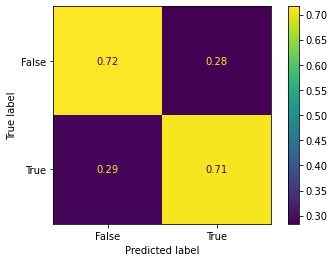

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

print("Year 1 Confusion Matrix")
(x_train, x_test, y_train, y_test, df)  = prepare_model_data.make_train_test(data, year=1, min_pop=None, regression=False, 
        split=True)

lrcv1 = LogisticRegressionCV(random_state=SEED, max_iter=1000).fit(x_train, y_train)

pred = lrcv1.predict(x_test)

x = ConfusionMatrixDisplay.from_predictions(pred, y_test, normalize='true')

Year 2 Confusion Matrix


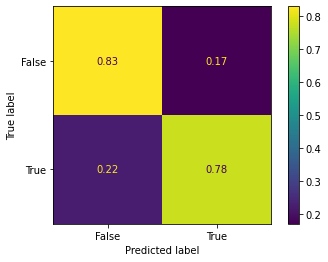

In [9]:
print("Year 2 Confusion Matrix")
(x_train, x_test, y_train, y_test, df)  = prepare_model_data.make_train_test(data, year=2, min_pop=None, regression=False, 
        split=True)

lrcv2 = LogisticRegressionCV(random_state=SEED, max_iter=1000).fit(x_train, y_train)

pred = lrcv2.predict(x_test)

x = ConfusionMatrixDisplay.from_predictions(pred, y_test, normalize='true')

We can use permutation importance to figure out what really matters to these models that we've built.

In [10]:
from sklearn.inspection import permutation_importance

df, X, y = prepare_model_data.make_train_test(data, year=1, min_pop=None, split=False)
best_model = LogisticRegressionCV(random_state=SEED, max_iter=1000).fit(X,y)

result = permutation_importance(best_model, X, y, n_repeats=100)

y1_importance = pd.Series(result.importances_mean, index=df.columns)

disp = y1_importance.reindex(y1_importance.abs().sort_values(ascending=False).index)

pt = PrettyTable()
pt.field_names = ['Factor', 'Importance (Year One)']

print("Year one")
#print(disp[disp > 0][:10])

for x in disp[disp > 0][:10].index:
    pt.add_row([x, round(disp[x], 3)])

print(pt)

Year one
+---------------------------------+-----------------------+
|              Factor             | Importance (Year One) |
+---------------------------------+-----------------------+
|         % Over 65 (SVI)         |         0.032         |
|      Life Expectancy (CHR)      |         0.025         |
| Physically Unhealthy Days (CHR) |          0.02         |
|         % Disabled (SVI)        |          0.02         |
|   % Physically Inactive (CHR)   |         0.018         |
|   Median Household (Wikipedia)  |         0.017         |
|          % Rural (CHR)          |         0.017         |
|      2016 Repub Vote Share      |         0.016         |
|  Mentally Unhealthy Days (CHR)  |         0.016         |
|         % Screened (CHR)        |         0.013         |
+---------------------------------+-----------------------+


In [11]:
df, X, y = prepare_model_data.make_train_test(data, year=2, min_pop=None, split=False)
best_model = LogisticRegressionCV(random_state=SEED, max_iter=1000).fit(X,y)

result = permutation_importance(best_model, X, y, n_repeats=100)

perm_importances = pd.Series(result.importances_mean, index=df.columns)

y2_importance = perm_importances.reindex(perm_importances.abs().sort_values(ascending=False).index)

# print("Year two")
# print(y2_importance[y2_importance > 0][:10])

pt = PrettyTable()
pt.field_names = ['Factor', 'Importance (Year Two)']

for x in y2_importance[:10].index:
    pt.add_row([x, round(y2_importance[x], 3)])

print(pt)

+--------------------------------+-----------------------+
|             Factor             | Importance (Year Two) |
+--------------------------------+-----------------------+
|     2016 Repub Vote Share      |         0.038         |
|     Teen Birth Rate (CHR)      |         0.018         |
|      % Some College (CHR)      |         0.017         |
|        % Hispanic (CHR)        |         0.016         |
|   % Insufficient Sleep (CHR)   |         0.016         |
|        % Diabetic (CHR)        |         0.016         |
|    % Limited English (SVI)     |         0.015         |
|         % Rural (CHR)          |         0.015         |
|       % Fair/Poor (CHR)        |         0.013         |
| Clinical Care Percentile (CHR) |         0.011         |
+--------------------------------+-----------------------+


These importances don't tell us the direction of the correlation (whether they increase or decrease the likelihood of a county having high COVID rates.) We can unite this data with the correlation data to show all factors that mattered during the pandemic. Let's see which factors showed up in one of the models and had a big change in correlation.

In [12]:
summary = y1_importance.rename('Y1_IMPORTANCE').to_frame()\
    .join(y1_corr.rename("Y1_CORR"))\
    .join(y2_importance.rename('Y2_IMPORTANCE'))\
    .join(y2_corr.rename("Y2_CORR"))

summary['CORR_DIFF'] = summary['Y2_CORR'] - summary['Y1_CORR']

#summary[(summary.Y1_IMPORTANCE > 0) & (summary.Y2_IMPORTANCE > 0)].sort_values(by='Y2_IMPORTANCE', ascending=False)

In [13]:
summary[(summary.Y1_IMPORTANCE > 0)].sort_values(by='Y1_IMPORTANCE', ascending=False)[:10]
#.sort_values(by='Y2_IMPORTANCE')[:10]
#.sort_values(by='CORR_DIFF', key=lambda x: abs(x), ascending=False)[:10]

,Y1_IMPORTANCE,Y1_CORR,Y2_IMPORTANCE,Y2_CORR,CORR_DIFF
% Over 65 (SVI),0.032299,0.061256,0.005368,0.239974,0.178718
Life Expectancy (CHR),0.025440,-0.284754,0.006005,-0.490274,-0.205519
Physically Unhealthy Days (CHR),0.020171,0.114035,0.008184,0.452853,0.338818
% Disabled (SVI),0.019997,0.090178,0.001004,0.482125,0.391947
% Physically Inactive (CHR),0.018058,0.298508,-0.000116,0.404044,0.105536
Median Household (Wikipedia),0.017448,-0.277863,0.003066,-0.434362,-0.156499
% Rural (CHR),0.017023,0.102122,0.014848,0.254303,0.152180
2016 Repub Vote Share,0.016256,0.136991,0.038342,0.419108,0.282117
Mentally Unhealthy Days (CHR),0.015944,0.015366,0.001107,0.418606,0.403240
% Screened (CHR),0.012751,-0.079571,0.004755,-0.331623,-0.252052


### What do other models say?

Let's run through several models and see what their top factors are for year two.

In [18]:
y2_ranks = y2_importance.rank(ascending=False)

#deaths.sort_values(ascending=False).index
#print(y2_ranks.sort_values())

runner_up_models = {
    'LinearSVC': LinearSVC(),
    'GradientBoost': GradientBoostingClassifier(),
    'Ridge': RidgeClassifierCV(),
    'RandomForest': RandomForestClassifier()
}
results = {}

import time

df, X, y = prepare_model_data.get_train_data(data, year=2)
for mod_name, model in runner_up_models.items():
    print(f"starting {mod_name}")
    start = time.time()
    fit_model = model.fit(X, y)

    print("strating permutation importance")
    result = permutation_importance(fit_model, X, y, n_repeats=100)

    perm_importances = pd.Series(result.importances_mean, index=df.columns).rank(ascending=False)

    results[mod_name] = perm_importances

    print(f"done with {mod_name} -- {time.time() - start}\n")

    #y2_linear_svc = perm_importances.reindex(perm_importances.abs().sort_values(ascending=False).index)


starting LinearSVC


/Users/caseydurfee/.virtualenvs/py3-data/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


strating permutation importance
done with LinearSVC -- 11.879898309707642

starting GradientBoost
strating permutation importance
done with GradientBoost -- 56.58074402809143

starting Ridge
strating permutation importance
done with Ridge -- 7.081863880157471

starting RandomForest
strating permutation importance
done with RandomForest -- 344.27408623695374



In [28]:

rows = []
for factor in results['LinearSVC'].index:
    mean_rank = (results['LinearSVC'][factor] + 
                results['GradientBoost'][factor] + 
                results['Ridge'][factor] + 
                results['RandomForest'][factor]) / 4
    
    if factor in y2_ranks:
        lrcv_rank = y2_ranks[factor]
    else:
        lrcv_rank = "N/A"
    
    row = [factor, mean_rank, lrcv_rank]
    #results['LinearSVC'][factor], results['GradientBoosting'][factor], 
    #        results['Ridge'][factor], mean_rank]
    #pt.add_row(row)

    rows.append(row)

mean_rank_df = pd.DataFrame(rows, columns=["Factor", "Mean Rank", "LRCV Rank"]).sort_values(by="LRCV Rank", ascending=True)

#mean_rank_df

pt = PrettyTable()
pt.field_names = ['Factor', 'LRCV Rank', 'Mean Rank'] #'LinearSVC', 'GradientBoosting', 'Ridge', 'Mean Rank']
for x in mean_rank_df.index[:20]:
    row = mean_rank_df.loc[x]
    pt.add_row([row['Factor'], int(row['LRCV Rank']), row['Mean Rank']])

print(pt)

+------------------------------------+-----------+-----------+
|               Factor               | LRCV Rank | Mean Rank |
+------------------------------------+-----------+-----------+
|       2016 Repub Vote Share        |     1     |    1.5    |
|       Teen Birth Rate (CHR)        |     2     |   16.25   |
|        % Some College (CHR)        |     3     |   10.25   |
|          % Hispanic (CHR)          |     4     |   23.125  |
|     % Insufficient Sleep (CHR)     |     5     |   39.125  |
|          % Diabetic (CHR)          |     6     |    9.25   |
|      % Limited English (SVI)       |     7     |   18.875  |
|           % Rural (CHR)            |     8     |   37.875  |
|         % Fair/Poor (CHR)          |     9     |    20.5   |
|   Clinical Care Percentile (CHR)   |     10    |    16.5   |
|           % Obese (CHR)            |     11    |   26.875  |
|  % Severe Housing Problems (CHR)   |     12    |   36.625  |
| % Frequent Physical Distress (CHR) |     13    |   27

### Big Counties only

We've been looking at all counties. However, many of the metrics we have are imputed by the sources we got them from (SVI, County Health Rankings, CDC, etc.) Those data sources provide confidence intervals on their estimations but we're not using those.

So it makes sense to look at just big US counties (over 50,000 population)

In [ ]:
df, X, y = prepare_model_data.make_train_test(data, year=2, min_pop=50000, split=False)

y2_bigcounty_model = LogisticRegressionCV(max_iter=20000).fit(X,y)

result = permutation_importance(y2_bigcounty_model, X, y, n_repeats=100)

perm_importances = pd.Series(result.importances_mean, index=df.columns)

y2_bigcounty_importance = perm_importances.reindex(perm_importances.abs().sort_values(ascending=False).index)

print("Year two - Big Counties Only")
print()




In [32]:
pt = PrettyTable()
pt.field_names = ['Factor', 'Importance'] 
for x in y2_bigcounty_importance[y2_bigcounty_importance > 0].index[:10]:
    pt.add_row([x, round(y2_bigcounty_importance.loc[x], 3)])

print(pt)

+--------------------------------+------------+
|             Factor             | Importance |
+--------------------------------+------------+
|     2016 Repub Vote Share      |   0.025    |
|    Segregation index (CHR)     |   0.016    |
|       Income Ratio (CHR)       |   0.015    |
|        % Over 65 (SVI)         |   0.015    |
|         % Female (CHR)         |   0.014    |
| Clinical Care Percentile (CHR) |   0.014    |
|   % Insufficient Sleep (CHR)   |   0.013    |
|         % Rural (CHR)          |   0.013    |
|  Infant Mortality Rate (CHR)   |   0.012    |
|     COVID Booster Coverage     |   0.011    |
+--------------------------------+------------+


Once again REPUB_PARTISAN is the strongest factor used by the model to predict high COVID fatality rates.

Finally, let's see how 

In [34]:
pt = PrettyTable()
pt.field_names = ['Classifier', 'Year 1', 'Year 2', 'Both', 'Total']

@ignore_warnings(category=ConvergenceWarning)
def do_classifiers(models):
    for model in models:
        df, X, y = prepare_model_data.make_train_test(data, year=1, min_pop=50000, split=False)
        mean_score1 = cross_val_score(model, X, y).mean()

        df, X, y = prepare_model_data.make_train_test(data, year=2, min_pop=50000, split=False)
        mean_score2 = cross_val_score(model, X, y).mean()

        df, X, y = prepare_model_data.make_train_test(data, year=None, min_pop=50000, split=False)
        mean_score_combined = cross_val_score(model, X, y).mean()

        score_sum = mean_score1 + mean_score2 + mean_score_combined

        pt.add_row([model.__class__.__name__[:18], round(mean_score1,3), round(mean_score2, 3), 
                    round(mean_score_combined, 3), round(score_sum, 3)])
    print(pt)

do_classifiers(classifier_models)

+--------------------+--------+--------+-------+-------+
|     Classifier     | Year 1 | Year 2 |  Both | Total |
+--------------------+--------+--------+-------+-------+
| RandomForestClassi | 0.731  | 0.798  | 0.778 | 2.307 |
|        SVC         | 0.739  | 0.806  | 0.783 | 2.328 |
| LogisticRegression | 0.731  | 0.811  | 0.791 | 2.333 |
| RidgeClassifierCV  | 0.718  |  0.79  | 0.747 | 2.254 |
| AdaBoostClassifier | 0.718  | 0.796  | 0.783 | 2.297 |
| BaggingClassifier  | 0.687  | 0.768  | 0.737 | 2.192 |
| GradientBoostingCl | 0.764  | 0.801  | 0.784 | 2.349 |
|     LinearSVC      | 0.701  | 0.768  | 0.755 | 2.224 |
+--------------------+--------+--------+-------+-------+


Year 1 Confusion Matrix


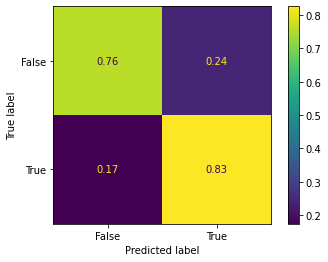

In [36]:
print("Year 1 Confusion Matrix")
(x_train, x_test, y_train, y_test, df)  = prepare_model_data.make_train_test(data, year=1, min_pop=50000, regression=False, 
        split=True)

lrcv2 = LogisticRegressionCV(random_state=SEED, max_iter=1000).fit(x_train, y_train)

pred = lrcv2.predict(x_test)

x = ConfusionMatrixDisplay.from_predictions(pred, y_test, normalize='true')

Year 2 Confusion Matrix


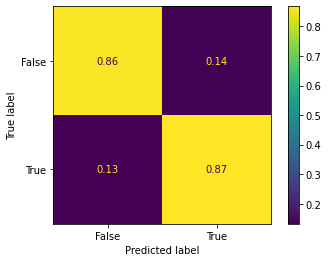

In [35]:
print("Year 2 Confusion Matrix")
(x_train, x_test, y_train, y_test, df)  = prepare_model_data.make_train_test(data, year=2, min_pop=50000, regression=False, 
        split=True)

lrcv2 = LogisticRegressionCV(random_state=SEED, max_iter=1000).fit(x_train, y_train)

pred = lrcv2.predict(x_test)

x = ConfusionMatrixDisplay.from_predictions(pred, y_test, normalize='true')

What percent of people in the US live in these bigger counties?

In [42]:
big_counties = data[data.POPULATION > 50000]

sum(big_counties.POPULATION) / sum(data.POPULATION)

0.8713329298014472

What is most strongly associated with 2016 Repub Vote Share?

In [50]:



# top_cols_in_either = y1_corr[:20].index.union(y2_corr[:20].index)

pt = PrettyTable()
pt.field_names = ['Name', 'r^2 with Repub vote']

repub_corr = data.corr()['2016 Repub Vote Share']

repub_corr = repub_corr.reindex(repub_corr.abs().sort_values(ascending=False).index) \
    .drop(death_cols).drop("2016 Repub Vote Share")

for x in repub_corr.index[:20]:
    pt.add_row([x, round(repub_corr[x], 3)])


print(pt)

# rows = []
# for c in top_cols_in_either:
#     row = [c, round(y1_corr[c], 3), round(y2_corr[c], 3)]
#     # pt.add_row(row)
#     rows.append(row)

# sorted_rows = sorted(rows, key=lambda x: abs(x[1]) + abs(x[2]), reverse=True)

# for x in sorted_rows:
#     pt.add_row(x)

# print(pt)

+----------------------------------+---------------------+
|               Name               | r^2 with Repub vote |
+----------------------------------+---------------------+
|      COVID Partial Coverage      |        -0.692       |
|     COVID Complete Coverage      |        -0.688       |
|      COVID Booster Coverage      |        -0.594       |
| % Severe Housing Problems (CHR)  |        -0.564       |
|    % Multiunit Housing (SVI)     |        -0.529       |
|    % Non-Hispanic White (CHR)    |         0.52        |
|         % Minority (SVI)         |        -0.518       |
|          % Rural (CHR)           |        0.469        |
|        % Homeowners (CHR)        |        0.467        |
|          % Asian (CHR)           |        -0.441       |
|       Chlamydia Rate (CHR)       |        -0.431       |
|     % African American (CHR)     |        -0.404       |
|    HIV Prevalence Rate (CHR)     |        -0.401       |
|   % Physically Inactive (CHR)    |        0.398       

In [54]:
disp = y2_corr.reindex(y2_corr.abs().sort_values(ascending=False).index)

print(disp.to_string())

Age-Adjusted Mortality (CHR)                  0.495016
Life Expectancy (CHR)                        -0.490274
% Disabled (SVI)                              0.482125
Years of Potential Life Lost Rate (CHR)       0.466963
Median Family (Wikipedia)                    -0.457310
Physically Unhealthy Days (CHR)               0.452853
Teen Birth Rate (CHR)                         0.450424
% Some College (CHR)                         -0.442925
COVID Complete Coverage                      -0.439520
Median Household (Wikipedia)                 -0.434362
COVID Booster Coverage                       -0.433765
% Diabetic (CHR)                              0.432851
% Frequent Physical Distress (CHR)            0.431779
% Frequent Mental Distress (CHR)              0.431077
Firearm Fatalities Rate (CHR)                 0.427629
Per Capita Income (SVI)                      -0.424035
COVID Partial Coverage                       -0.420090
2016 Repub Vote Share                         0.419108
Mentally U